## Reproducible Deep Learning (PhD course, Data Science)
### Lecture 1: deep learning recap

We will code a simple audio classification model (a convolutional neural network) for the ESC-50 dataset: https://github.com/karolpiczak/ESC-50. The aim is to recap some deep learning concepts, and have a working notebook to use as starting point for the next exercises.

**Setup the machine**:
1. Follow the instructions from here: https://github.com/sscardapane/reprodl2021#local-set-up
2. Download the ESC-50 dataset inside a 'data' folder.

In [1]:
import torch
import torchaudio
from torch import nn
from torch.nn import functional as F

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.metrics import functional

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
torch.cuda.is_available()

False

In [106]:
import IPython.display as ipd


### Step 1: Some experiments in audio loading and transformation

The code in this section is just for experimentation, and will be removed when porting to a script.

In [11]:
# Substitute this with your actual path. This is the root folder of ESC-50, where
# you can find the subfolders 'audio' and 'meta'.
path = '/Users/carloabrate/Desktop/phd/exam_reprodl/examples'
datapath = Path(path+'/ESC-50-master')

In [12]:
datapath.exists()

True

In [13]:
# Using Path is fundamental to have reproducible code across different operating systems.
csv = pd.read_csv(datapath / Path('meta/esc50.csv'))

In [14]:
# We need only filename, fold, and target
csv.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


In [15]:
# We can use torchaudio.load to load the file. The second value is the sampling rate of the file.
x, sr = torchaudio.load(datapath / 'audio' / csv.iloc[0, 0], normalize=True)

In [16]:
x.shape

torch.Size([1, 220500])

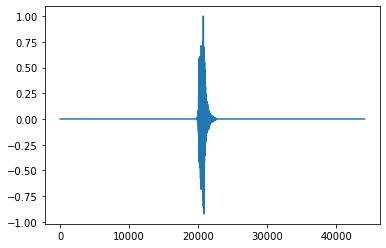

In [17]:
plt.plot(x[0, ::5])

In [69]:
# Useful transformation to resample the original file.
resempling_rate_freq = 8000
torchaudio.transforms.Resample(orig_freq=sr, new_freq=resempling_rate_freq)(x).shape

torch.Size([1, 40000])

In [70]:
# Another useful transformation to build a Mel spectrogram (image-like), so that
# we can apply any CNN on top of it.
h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(x)

/opt/anaconda3/envs/reprodl/lib/python3.9/site-packages/torchaudio/functional/functional.py:432: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [71]:
h.shape

torch.Size([1, 128, 1103])

In [21]:
# Convert to DB magnitude, useful for scaling.
# Note: values could be further normalize to significantly speed-up and simplify training.
h = torchaudio.transforms.AmplitudeToDB()(h)

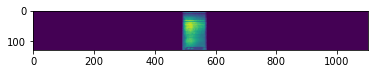

In [22]:
plt.imshow(h[0])

### Step 2: Putting together data loading and preprocessing

In [32]:
class ESC50Dataset(torch.utils.data.Dataset):
    # Simple class to load the desired folders inside ESC-50
    
    def __init__(self, path: Path = Path(path+'/ESC-50-master'), 
                 sample_rate: int = 8000,
                 folds = [1]):
        # Load CSV & initialize all torchaudio.transforms:
        # Resample --> MelSpectrogram --> AmplitudeToDB
        self.path = path
        self.csv = pd.read_csv(path / Path('meta/esc50.csv'))
        self.csv = self.csv[self.csv['fold'].isin(folds)]
        self.resample = torchaudio.transforms.Resample(
            orig_freq=44100, new_freq=sample_rate
        )
        self.melspec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate)
        self.db = torchaudio.transforms.AmplitudeToDB(top_db=80)
        
        
    def __getitem__(self, index):
        # Returns (xb, yb) pair, after applying all transformations on the audio file.
        row = self.csv.iloc[index]
        wav, _ = torchaudio.load(self.path / 'audio' / row['filename'])
        label = row['target']
        xb = self.db(
            self.melspec(
                self.resample(wav)
            )
        )
        return xb, label
        
    def __len__(self):
        # Returns length
        return len(self.csv)

In [33]:
train_data = ESC50Dataset()

In [50]:
for xb, yb in train_data:
    print(len(xb[0]),yb)
    break

128 0


In [35]:
xb.shape

torch.Size([1, 128, 201])

In [36]:
yb

0

### Step 3: Build a classification model (to run only if you want to train the model again, otherwise jump to the adversarial creation and load the model)

In [73]:
n_classes = 50
base_filters = 32

In [51]:
# We use folds 1,2,3 for training, 4 for validation, 5 for testing.
train_data = ESC50Dataset(folds=[1,2,3])
val_data = ESC50Dataset(folds=[4])
test_data = ESC50Dataset(folds=[5])

In [52]:
train_loader = \
    torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True)

In [53]:
val_loader = torch.utils.data.DataLoader(val_data, batch_size=8)

In [54]:
test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)

In [55]:
class AudioNet(pl.LightningModule):
    
    def __init__(self, n_classes = 50, base_filters = 32):
        super().__init__()
        self.conv1 = nn.Conv2d(1, base_filters, 11, padding=5)
        self.bn1 = nn.BatchNorm2d(base_filters)
        self.conv2 = nn.Conv2d(base_filters, base_filters, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(base_filters)
        self.pool1 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(base_filters, base_filters * 2, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(base_filters * 2)
        self.conv4 = nn.Conv2d(base_filters * 2, base_filters * 4, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(base_filters * 4)
        self.pool2 = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(base_filters * 4, n_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool1(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool2(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.fc1(x[:, :, 0, 0])
        return x
    
    def training_step(self, batch, batch_idx):
        # Very simple training loop
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = functional.accuracy(y_hat, y)
        self.log('val_acc', acc, on_epoch=True, prog_bar=True)
        return acc
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [56]:
pl.seed_everything(0)

Global seed set to 0


0

In [57]:
# Test that the network works on a single mini-batch
audionet = AudioNet()
xb, yb = next(iter(train_loader))
audionet(xb).shape

torch.Size([8, 50])

In [59]:
trainer = pl.Trainer(gpus=0, max_epochs=25)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [60]:
trainer.fit(audionet, train_loader, val_loader)


   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 3.9 K 
1  | bn1   | BatchNorm2d | 64    
2  | conv2 | Conv2d      | 9.2 K 
3  | bn2   | BatchNorm2d | 64    
4  | pool1 | MaxPool2d   | 0     
5  | conv3 | Conv2d      | 18.5 K
6  | bn3   | BatchNorm2d | 128   
7  | conv4 | Conv2d      | 73.9 K
8  | bn4   | BatchNorm2d | 256   
9  | pool2 | MaxPool2d   | 0     
10 | fc1   | Linear      | 6.5 K 
---------------------------------------
112 K     Trainable params
0         Non-trainable params
112 K     Total params
0.450     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/opt/anaconda3/envs/reprodl/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/opt/anaconda3/envs/reprodl/lib/python3.9/site-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
Global seed set to 0
/opt/anaconda3/envs/reprodl/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [62]:
# TODO: implement the test loop.
trainer.test(audionet, test_loader)

[]

In [63]:
# Save
model_path = '/Users/carloabrate/Desktop/phd/exam_reprodl/reprodl2021/models/audionet_model'
torch.save(audionet.state_dict(), model_path)

### 4. Create Adversarial Examples

In [148]:
# Load the model
model_path = '/Users/carloabrate/Desktop/phd/exam_reprodl/reprodl2021/models/audionet_model'
audionet_loaded = AudioNet()
audionet_loaded.load_state_dict(torch.load(model_path))
audionet_loaded.eval()

AudioNet(
  (conv1): Conv2d(1, 32, kernel_size=(11, 11), stride=(1, 1), padding=(5, 5))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=128, out_features=50, bias=True)
)

With the ART library, we can perform adversarial attacks to the instances in the model.
In partiular, with a Projected Gradient Descent attack we can observ that the attack corrupts the audio and so the classifier misclassifies the adversarial instance. 
However, there is almost no hearable difference in the original audio file and the adversarial audio file.

In [66]:
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import PyTorchClassifier
from art import config
from art.defences.preprocessor import Mp3Compression
from art.utils import get_file

In [121]:
# wrap model in a ART classifier
classifier_art = PyTorchClassifier(
    model=audionet,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=None,
    #optimizer=torch.optim.Adam(),
    input_shape=[1, resempling_rate_freq],
    nb_classes=n_classes,
    clip_values=(-2**15, 2**15 - 1)
)

In [145]:
# load a test sample
id_data = 100
waveform,label = train_data[id_data]

In [146]:
# craft adversarial example with PGD
epsilon = .1
pgd = ProjectedGradientDescent(classifier_art, eps=epsilon)
adv_waveform = pgd.generate(
    x=torch.unsqueeze(waveform, 0).numpy()
)

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [147]:
# evaluate the classifier on the adversarial example
with torch.no_grad():
    _, pred = torch.max(audionet(torch.unsqueeze(waveform, 0)), 1)
    _, pred_adv = torch.max(audionet(torch.from_numpy(adv_waveform)), 1)

# print results
print(f"Original prediction (ground truth):\t{pred.tolist()[0]} ({label})")
print(f"Adversarial prediction:\t\t\t{pred_adv.tolist()[0]}")

Original prediction (ground truth):	9 (2)
Adversarial prediction:			47


### Visualize the original and the adversarial waveform

In [136]:
def display_waveform(waveform, title="", sr=8000):
    """Display waveform plot and audio play UI."""
    plt.figure()
    plt.title(title)
    plt.plot(waveform)
    ipd.display(ipd.Audio(waveform, rate=sr))

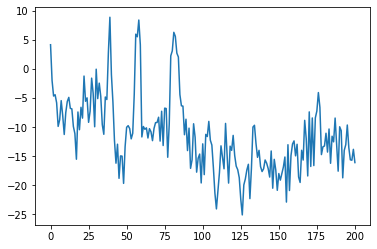

In [137]:
display_waveform(waveform[0,100,:])

In [138]:
# Another useful transformation to build a Mel spectrogram (image-like), so that
# we can apply any CNN on top of it.
#h = torchaudio.transforms.MelSpectrogram(sample_rate=sr)(waveform)
# Convert to DB magnitude, useful for scaling.
# Note: values could be further normalize to significantly speed-up and simplify training.
h = torchaudio.transforms.AmplitudeToDB()(waveform)

Text(0.5, 1.0, 'Original Waveform')

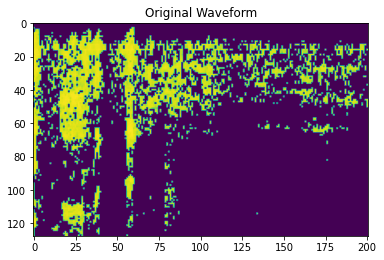

In [139]:
plt.imshow(h[0])
plt.title('Original Waveform')

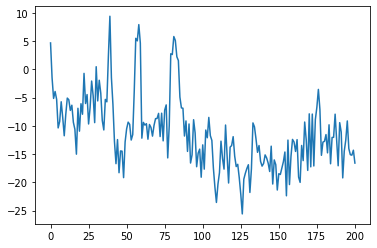

In [140]:
adv_waveform = torch.from_numpy(adv_waveform)[0]
display_waveform(adv_waveform[0,100,:])

In [141]:
h_adv = torchaudio.transforms.AmplitudeToDB()(adv_waveform)

Text(0.5, 1.0, 'Adversarial Waveform')

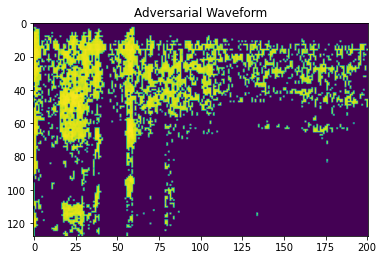

In [142]:
plt.imshow(h_adv[0])
plt.title('Adversarial Waveform')